## Python Odd-Even Solvers

Below are a numpy and Thomas algorithm implementation of cyclic reduction. They are generally numerically stable but have significantly slower runtimes compared to C and CUDA implementations.

Feel free to test different matrices by modifying n, A_mat and b_vec, which represent matrix dimensions, matrix A, and vector b in the equation Ax = b, respectively.

In [ ]:
import numpy as np
import time

# Function to generate a tridiagonal matrix A and vector b for testing
# The current sample tridiagonal matrix has the following structure:
# A = [[4, 1, 0, ..., 0],
#      [1, 4, 1, ..., 0],
#      [0, 1, 4, ..., 0],
#      ...
#      [0, ..., 1, 4]]
# b is a simple range from 1 to n, where n is the size of the matrix.
def generate_tridiagonal(n):
    A = np.zeros((n, n), dtype=float)
    b = np.arange(1,n+1, dtype=float)
    for i in range(n):
        A[i,i] = 4
        if i >0:
            A[i,i-1] = 1
        if i <n-1:
            A[i,i+1] = 1
    return A,b

# Implementation of Thomas algorithm
def thomasAlgo(A, b):
    n = len(b)
    c = np.zeros(n-1,dtype=float)
    d = np.zeros(n,dtype=float)
    x = np.zeros(n,dtype=float)

    # Forward elimination
    d[0] = A[0, 0]
    c[0] = A[0,1]/d[0]
    b[0] = b[0]/d[0]
    for i in range(1,n-1):
        d[i] = A[i,i] - A[i,i-1]*c[i -1]
        c[i] = A[i,i+1]/d[i]
        b[i] = (b[i] - A[i,i-1]*b[i-1])/d[i]

    d[n-1] = A[n-1, n-1] - A[n-1, n-2] *c[n-2]
    b[n-1] = (b[n-1] - A[n-1, n-2]* b[n-2])/d[n-1]
    # Back substitution
    x[n-1] = b[n-1]
    for i in range(n-2, -1, -1):
        x[i] = b[i] - c[i] * x[i + 1]
    return x

# Main testing code
n = 10000  # You can change this to any size
A,b = generate_tridiagonal(n)

print("Testing for matrix size:", n)
print()

# NumPy solver
start_time = time.time()
x_numpy = np.linalg.solve(A, b)
end_time = time.time()
runtime_numpy = end_time - start_time
print("Numpy solution (first 10 elements):", x_numpy[:10])
print("Numpy solution time:", runtime_numpy)
print()

# Thomas algorithm solver
start_time = time.time()
x_thomas = thomasAlgo(A, b)
end_time = time.time()
runtime_thomas = end_time - start_time
print("Thomas solution (first 10 elements):", x_thomas[:10])
print("Thomas solution time:", runtime_thomas)
print()

#Sample tridiagonal from wiki
A_mat = np.array([
    [1, 4, 0, 0],
    [3, 4, 1, 0],
    [0, 2, 3, 4],
    [0, 0, 1, 3]
], dtype=float)
b_vec = np.array([1, 2, 3, 4], dtype=float)

print("Testing for inputted matrix:")
print()

start_time = time.time()
x_numpy = np.linalg.solve(A_mat, b_vec)
end_time = time.time()
runtime_numpy = end_time - start_time
print("Numpy solution:", x_numpy)
print("Numpy solution time:", runtime_numpy)
print()

# Thomas algorithm solver
start_time = time.time()
x_thomas = thomasAlgo(A_mat, b_vec)
end_time = time.time()
runtime_thomas = end_time - start_time
print("Thomas solution:", x_thomas)
print("Thomas solution time:", runtime_thomas)
print()

Testing for matrix size: 10000

Numpy solution (first 10 elements): [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.
 1.16666667 1.33333333 1.5        1.66666667]
Numpy solution time: 22.463435173034668

Thomas solution (first 10 elements): [0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.
 1.16666667 1.33333333 1.5        1.66666667]
Thomas solution time: 0.023854970932006836

Numpy solution: [ 1.17391304 -0.04347826 -1.34782609  1.7826087 ]
Numpy solution time: 0.00011110305786132812

Thomas solution: [ 1.17391304 -0.04347826 -1.34782609  1.7826087 ]
Thomas solution time: 8.463859558105469e-05



## Sequential C Odd-Even Solver

We implemented cyclic reduction first sequentially in C.

To test custom matrices, modify diagSz_2 to a given dimension. You will also need to modify the following lists:
*   alist1: Represents entries along the diagonal just below the main diagonal (subdiagonal)
*   blist1: Represents entries along the main diagonal
*   clist1: Represents entries along the diagonal just below the main diagonal (superdiagonal)
*   dlist1: Represents entries in the b vector within Ax = b
*   xlist1: Values are arbitrary as it represents the solution vector x

In [ ]:
%%writefile cyclic_reduction.c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

// Essentially calcualtes the max number of iterations required for cyclic reduction to solve a matrix.
int count(int binary) {
    int m = 0;
    int cnt = 0;
    while (binary != 0)
    {
        m += binary % 2;
        binary = binary >> 1;
        cnt++;
    }
    cnt--;
    if (m > 1)
    {
        m = 0;
    }
    return (cnt-m);
}

typedef struct {
    int diag_size; // Size of matrix diagonal
    int iter_max; // Max # of iterations for cyclic reductio
} PCR_Solver;

void PCR_Solver_Init(PCR_Solver* solver, int ds) {
    solver->diag_size = ds;
    solver->iter_max = count(ds);
}

// Main solve method
void Solve(float* alist, float* blist, float* clist, float* dlist, float* xlist, int iter_max, int dmax) {
    int stride = 1;
    for (int i = 0; i < iter_max; i++) {
        for (int row = 0; row < dmax; row++) {
            float a1, b1, c1, d1;
            float k1, k2, c2, a2, d2, d3;
            // Update 'a' here
            if (row - stride < 0) {
                a1 = 0.0f;
                k1 = 0.0f;
                c2 = 0.0f;
                d2 = 0.0f;
            } else {
                k1 = alist[row]/blist[row-stride];
                a1 = -alist[row-stride] * k1;
                c2 = clist[row-stride] *k1;
                d2 = dlist[row-stride]*k1;
            }

            // Update 'c' here
            if (row+stride >= dmax) {
                c1 = 0.0f;
                k2 = 0.0f;
                a2 = 0.0f;
                d3 = 0.0f;
            } else {
                k2 = clist[row] / blist[row+stride];
                c1 = -clist[row+stride] * k2;
                a2 = alist[row+stride] * k2;
                d3 = dlist[row+stride] * k2;
            }

            // Update 'b' here
            b1 = blist[row]-c2-a2;
            // Update 'd' here
            d1 = dlist[row]-d2-d3;
            alist[row] = a1;
            blist[row] = b1;
            clist[row] = c1;
            dlist[row] = d1;
        }
        stride <<= 1;
    }

    for (int row = 0; row < dmax; row++) {
        if (row-stride < 0) {
            int i = row;
            int k = row + stride;
            if (k < dmax) {
                float f = clist[i]/blist[k];
                xlist[i] = (dlist[i]-dlist[k]*f)/(blist[i]-alist[k]*f);
            } else {
                xlist[i] = dlist[i]/blist[i];
            }
        }
        else
        {
            int i = row -stride;
            int k = row;
            float f = alist[k]/blist[i];
            xlist[k] = (dlist[k]-dlist[i] * f)/(blist[k]-clist[i]*f);
        }
    }
}

// Generates the tridiagonal matrix user inputted
void gen_tridiagonal(int n, float* alist, float* blist, float* clist, float* dlist) {
    for (int i = 0; i < n; i++)
    {
        blist[i] = 4.0f; // Main diagonal
        dlist[i] = (float)(i + 1); // b vector in Ax=b

        if (i > 0) {
            alist[i] = 1.0f; // Diagonal just below main
        }
        else
        {
            alist[i] = 0.0f;
        }
        if (i < n-1) {
            clist[i] = 1.0f; // Diagonal just above main
        }
        else
        {
            clist[i] = 0.0f;
        }
    }
}

int main() {
    // Hardcoded test case
    printf("Running hardcoded test case:\n");
    float alist1[4] = {0.0, 3.0, 2.0, 1.0}; // Diagonal just below main
    float blist1[4] = {1.0, 4.0, 3.0, 3.0}; // Main diagonal
    float clist1[4] = {4.0, 1.0, 4.0, 0.0}; // Diagonal just above main
    float dlist1[4] = {1.0, 2.0, 3.0, 4.0};
    float xlist1[4] = {0.0, 0.0, 0.0, 0.0}; // Solution vector
    int diagSz_1 = 4;

    PCR_Solver solver1;
    PCR_Solver_Init(&solver1, diagSz_1);
    Solve(alist1, blist1, clist1, dlist1, xlist1, solver1.iter_max, diagSz_1);

    // Output results
    for (int i = 0; i < diagSz_1; i++) {
        printf("x[%d] = %f\n", i, xlist1[i]);
    }

    // Dynamically generated test case
    printf("\nRunning dynamically generated test case:\n");
    int diagSz_2 = 100;

    // Allocate memory dynamically based on the diagonal size
    float* alist2 = (float*)malloc(diagSz_2 *sizeof(float));
    float* blist2 = (float*)malloc(diagSz_2 * sizeof(float));
    float* clist2 = (float*)malloc(diagSz_2 * sizeof(float));
    float* dlist2 = (float*)malloc(diagSz_2 * sizeof(float));
    float* xlist2 = (float*)malloc(diagSz_2 * sizeof(float));

    if (!alist2 || !blist2 || !clist2 || !dlist2 || !xlist2)
    {
        fprintf(stderr, "Memory allocation failed\n");
        return -1;
    }

    // Generate the matrix and vector
    gen_tridiagonal(diagSz_2, alist2, blist2, clist2, dlist2);
    PCR_Solver solver2;
    PCR_Solver_Init(&solver2, diagSz_2);

    // Measuring runtime
    clock_t start_time = clock();
    printf("Testing for matrix size: %d\n",diagSz_2);
    Solve(alist2, blist2, clist2, dlist2, xlist2, solver2.iter_max, diagSz_2);
    clock_t end_time = clock();
    double runtime = (double)(end_time-start_time)/CLOCKS_PER_SEC;
    printf("Runtime for diagonal size %d: %f seconds\n", diagSz_2, runtime);

    // Output results for generated test case
    for (int i = 0; i < 10; i++) {
        printf("x[%d] = %f\n", i, xlist2[i]);
    }
    free(alist2);
    free(blist2);
    free(clist2);
    free(dlist2);
    free(xlist2);
    return 0;
}

Overwriting cyclic_reduction.c


In [ ]:
!gcc -o cyclic_reduction cyclic_reduction.c -lm
!./cyclic_reduction

Running hardcoded test case:
x[0] = 0.786408
x[1] = 0.835834
x[2] = -0.572816
x[3] = 1.524272

Running dynamically generated test case:
Testing for matrix size: 100
Runtime for diagonal size 100: 0.000022 seconds
x[0] = 0.166817
x[1] = 0.336406
x[2] = 0.502257
x[3] = 0.669138
x[4] = 0.835748
x[5] = 1.002430
x[6] = 1.169093
x[7] = 1.335760
x[8] = 1.502427
x[9] = 1.669094


## Parallelized CUDA Odd-Even Solver

To see the full effects of parallelization, make sure you are able to connect to some form of GPU prior to running.
To test custom matrices, modify diagSz_2 to a given dimension. You will also need to modify the following lists:
*   alist1: Represents entries along the diagonal just below the main diagonal (subdiagonal)
*   blist1: Represents entries along the main diagonal
*   clist1: Represents entries along the diagonal just below the main diagonal (superdiagonal)
*   dlist1: Represents entries in the b vector within Ax = b
*   xlist1: Values are arbitrary as it represents the solution vector x

In [ ]:
!rm -f cyclic_reduction_cuda.o cyclic_reduction_cuda


In [ ]:
%%writefile cyclic_reduction_cuda.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>

// Function to count iterations
__host__ __device__ int cnt(int binary) {
    int m = 0;
    int cnt = 0;

    while (binary != 0)
    {
        m += binary%2;
        binary = binary >> 1;
        cnt++;
    }
    cnt--;
    if (m > 1)
    {
        m = 0;
    }
    return cnt-m;
}

// Kernel for forward reduction
__global__ void forward_red(float* alist,float* blist,float* clist,float* dlist,int stride,int n) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;

    if (idx >= n)
    {
        return;
    }

    float b1, d1;
    float k1 = 0.0f, k2 = 0.0f, c1 = 0.0f, a2 = 0.0f, d2 = 0.0f, d3 = 0.0f;

    // Update 'a' here
    if (idx-stride >= 0)
    {
        k1 = alist[idx] / blist[idx-stride];
        c1 = clist[idx-stride] * k1;
        d2 = dlist[idx-stride] * k1;
    }
    // Update 'c' here
    if (idx+stride < n)
    {
        k2 = clist[idx]/blist[idx+stride];
        a2 = alist[idx+stride]*k2;
        d3 = dlist[idx+stride]* k2;
    }

    // Update 'b' and 'd'  here
    b1 = blist[idx]-c1-a2;
    d1 = dlist[idx]-d2- d3;
    //To ensure numeric stability
    __syncthreads();

    if (idx - stride >= 0)
    {
        alist[idx] = -alist[idx-stride]*k1;
    } else {
        alist[idx] = 0.0f;
    }
    blist[idx] = b1;
    if (idx + stride < n)
    {
        clist[idx] = -clist[idx+stride]*k2;
    } else {
        clist[idx] = 0.0f;
    }
    dlist[idx] = d1;
}

// Kernel for backward substitution
__global__ void back_sub(float* alist, float* blist, float* clist, float* dlist, float* xlist, int stride, int n) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;

    if (idx >= n)
    {
        return;
    }

    if (stride == 1||idx-stride < 0 ||idx+stride >= n)
    {
        xlist[idx] = dlist[idx] / blist[idx];
    } else {
        int i = idx - stride;
        float f = alist[idx]/blist[i];
        xlist[idx] = (dlist[idx]-dlist[i]*f)/(blist[idx]-clist[i]*f);
    }
}

// Generates the tridiagonal matrix user inputted
void gen_tridiagonal(int n, float* alist, float* blist, float* clist, float* dlist) {
    for (int i = 0; i < n; i++) {
        blist[i] = 4.0f;  // Main diagonal
        dlist[i] = (float)(i+1);  // b vector in Ax=b
        if (i > 0)
        {
            alist[i] = 1.0f;  // Diagonal just below main
        }
        else
        {
            alist[i] = 0.0f;
        }

        if (i < n- 1)
        {
            clist[i] = 1.0f; //Diagonal just above main
        }
        else
        {
            clist[i] = 0.0f;
        }
    }
}
int main() {
    // Hardcoded test case
    printf("Running hardcoded test case:\n");
    float alist1[4] = {0.0, 3.0, 2.0, 1.0}; // Diagonal just below main
    float blist1[4] = {1.0, 4.0, 3.0, 3.0}; // Main diagonal
    float clist1[4] = {4.0, 1.0, 4.0, 0.0}; // Diagonal just above main
    float dlist1[4] = {1.0, 2.0, 3.0, 4.0};
    float xlist1[4] = {0.0, 0.0, 0.0, 0.0}; // Solution vector
    int diagSz_1 = 4;

    // Allocate mem
    float *d_a1, *d_b1, *d_c1, *d_d1, *d_x1;
    cudaMalloc(&d_a1, diagSz_1*sizeof(float));
    cudaMalloc(&d_b1, diagSz_1*sizeof(float));
    cudaMalloc(&d_c1,diagSz_1*sizeof(float));
    cudaMalloc(&d_d1, diagSz_1*sizeof(float));
    cudaMalloc(&d_x1, diagSz_1*sizeof(float));
    // Copy data to device
    cudaMemcpy(d_a1, alist1, diagSz_1*sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_b1, blist1, diagSz_1*sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_c1, clist1, diagSz_1*sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_d1, dlist1, diagSz_1*sizeof(float), cudaMemcpyHostToDevice);

    // Some kernel parameters
    int threads_per_block = 256;
    int blocks_per_grid1 = (diagSz_1+threads_per_block-1) / threads_per_block;
    // Forward reduction
    for (int stride = 1; stride < diagSz_1; stride <<= 1)
    {
        forward_red<<<blocks_per_grid1, threads_per_block>>>(d_a1, d_b1, d_c1, d_d1, stride, diagSz_1);
        cudaDeviceSynchronize(); // Sync each time
    }
    // Backward substitution
    for (int stride = diagSz_1 / 2; stride > 0; stride >>= 1)
    {
        back_sub<<<blocks_per_grid1, threads_per_block>>>(d_a1, d_b1, d_c1, d_d1, d_x1, stride, diagSz_1);
        cudaDeviceSynchronize();
    }
    // Copy back to host
    cudaMemcpy(xlist1,d_x1,diagSz_1*sizeof(float),cudaMemcpyDeviceToHost);

    // Results here
    for (int i = 0; i < diagSz_1; i++) {
        printf("x[%d] = %f\n", i, xlist1[i]);
    }
    cudaFree(d_a1);
    cudaFree(d_b1);
    cudaFree(d_c1);
    cudaFree(d_d1);
    cudaFree(d_x1);

    // Repeat everything from above but with dynamically generated test case
    printf("\nRunning dynamically generated test case:\n");
    int diagSz_2 = 100;
    float* alist2 = (float*)malloc(diagSz_2 * sizeof(float));
    float* blist2 = (float*)malloc(diagSz_2 * sizeof(float));
    float* clist2 = (float*)malloc(diagSz_2 * sizeof(float));
    float* dlist2 = (float*)malloc(diagSz_2 * sizeof(float));
    float* xlist2 = (float*)malloc(diagSz_2 * sizeof(float));
    gen_tridiagonal(diagSz_2, alist2, blist2, clist2, dlist2);

    float *d_a2, *d_b2, *d_c2, *d_d2, *d_x2;
    cudaMalloc(&d_a2, diagSz_2 * sizeof(float));
    cudaMalloc(&d_b2, diagSz_2 * sizeof(float));
    cudaMalloc(&d_c2, diagSz_2 * sizeof(float));
    cudaMalloc(&d_d2, diagSz_2 * sizeof(float));
    cudaMalloc(&d_x2, diagSz_2 * sizeof(float));

    // Copy data to device
    cudaMemcpy(d_a2, alist2, diagSz_2 * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_b2, blist2, diagSz_2 * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_c2, clist2, diagSz_2 * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_d2, dlist2, diagSz_2 * sizeof(float), cudaMemcpyHostToDevice);

    int blocks_per_grid2 = (diagSz_2+threads_per_block-1)/threads_per_block;
    // Use cudaEvents to record runtime
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start);

    // Forward reduction
    for (int stride = 1; stride < diagSz_2; stride <<= 1)
    {
        forward_red<<<blocks_per_grid2, threads_per_block>>>(d_a2, d_b2, d_c2, d_d2, stride, diagSz_2);
        cudaDeviceSynchronize();
    }
    // Backward substitution
    for (int stride = diagSz_2 / 2; stride > 0; stride >>= 1)
    {
        back_sub<<<blocks_per_grid2, threads_per_block>>>(d_a2, d_b2, d_c2, d_d2, d_x2, stride, diagSz_2);
        cudaDeviceSynchronize();
    }

    cudaMemcpy(xlist2, d_x2, diagSz_2 * sizeof(float), cudaMemcpyDeviceToHost);

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    float sec = 0;
    cudaEventElapsedTime(&sec,start,stop);
    sec /= 1000.0f;  // s --> ms

    printf("Testing for matrix size: %d\n", diagSz_2);
    printf("Runtime: %f seconds\n", sec);
    for (int i = 0; i < 10; i++) {
        printf("x[%d] = %f\n", i, xlist2[i]);
    }
    free(alist2);
    free(blist2);
    free(clist2);
    free(dlist2);
    free(xlist2);
    cudaFree(d_a2);
    cudaFree(d_b2);
    cudaFree(d_c2);
    cudaFree(d_d2);
    cudaFree(d_x2);
    return 0;
}

Overwriting cyclic_reduction_cuda.cu


In [ ]:
!nvcc cyclic_reduction_cuda.cu -o cyclic_reduction_cuda
!./cyclic_reduction_cuda

Running hardcoded test case:
x[0] = 1.173913
x[1] = -0.043478
x[2] = -1.347826
x[3] = 1.782609

Running dynamically generated test case:
Testing for matrix size: 100
Runtime: 0.000190 seconds
x[0] = 0.166667
x[1] = 0.333333
x[2] = 0.500000
x[3] = 0.666667
x[4] = 0.833333
x[5] = 1.000000
x[6] = 1.166667
x[7] = 1.333333
x[8] = 1.500000
x[9] = 1.666667


### Results

Below are line plots and bar graphs to visualize the performance/runtime of each algorithm as the matrix scales by factors of 10.


In [ ]:
import numpy as np
matrix_sizes = [100, 1000, 10000]
methods = ['Numpy (np.linalg.solve)', 'Thomas', 'Odd-Even', 'CUDA Odd-Even']

# Times for each method and matrix size
times = {
    'Numpy (np.linalg.solve)': [0.0023148059844970703, 0.03362631797790527, 20.701850652694702],
    'Thomas': [0.0005390644073486328, 0.005964040756225586, 0.02482318878173828],
    'Odd-Even': [0.000019, 0.000276, 0.003226],
    'CUDA Odd-Even': [0.000190, 0.000236, 0.000435]
}
times_array = np.array(list(times.values()))

# Plotting the graph
fig, ax = plt.subplots(figsize=(12, 8))
for i, method in enumerate(methods):
    ax.plot(matrix_sizes, times_array[i], label=method, marker='o', linewidth=2)

ax.set_title('Performance Comparison Across Matrix Sizes', fontsize=14)
ax.set_xlabel('Matrix Size', fontsize=12)
ax.set_ylabel('Runtime (seconds)', fontsize=12)
ax.set_xscale('log')  # Log scale for matrix sizes
ax.set_yscale('log')  # Log scale for runtimes
ax.grid(which='both', linestyle='--', alpha=0.7)
ax.legend()

plt.show()

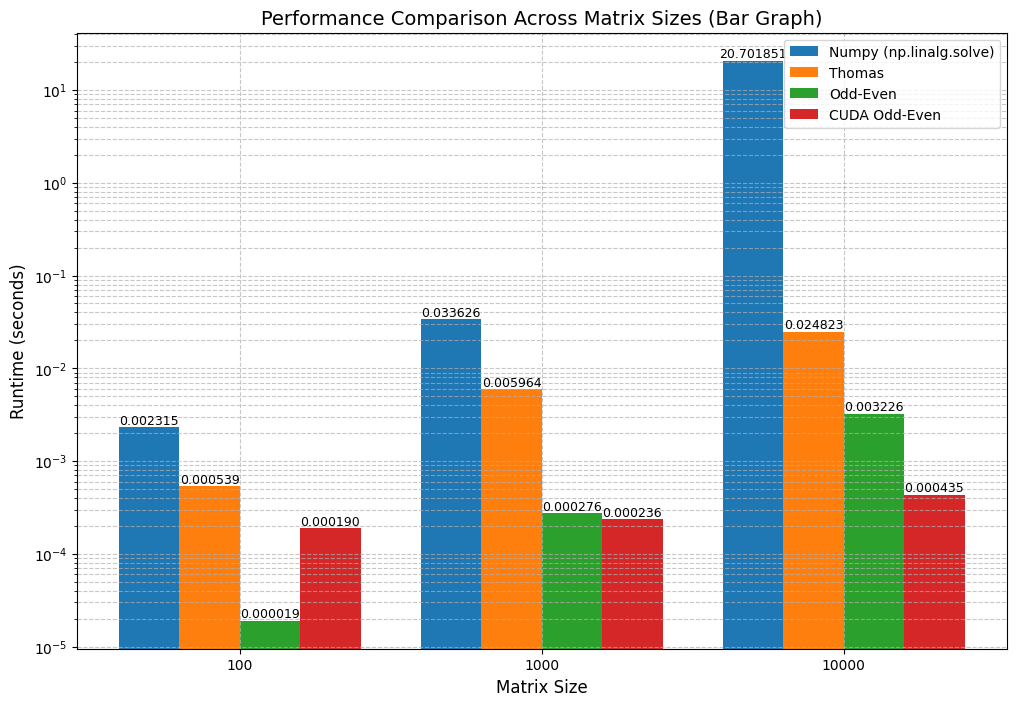

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Updated data for runtimes (in seconds)
times = {
    'Numpy (np.linalg.solve)': [0.0023148059844970703, 0.03362631797790527, 20.701850652694702],
    'Thomas': [0.0005390644073486328, 0.005964040756225586, 0.02482318878173828],
    'Odd-Even': [0.000019, 0.000276, 0.003226],
    'CUDA Odd-Even': [0.000190, 0.000236, 0.000435]
}

# Labels for the matrix sizes
labels = ['100', '1000', '10000']
methods = list(times.keys())
x = np.arange(len(labels))  # Label locations

bar_width = 0.2
fig, ax = plt.subplots(figsize=(12, 8))

# Adding bars for each method and annotating runtimes
for i, method in enumerate(methods):
    bars = ax.bar(x + i * bar_width, times[method], width=bar_width, label=method)
    # Annotate each bar with the runtime value
    for bar, runtime in zip(bars, times[method]):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                f"{runtime:.6f}", ha='center', va='bottom', fontsize=9)

# Adding labels and title
ax.set_title('Performance Comparison Across Matrix Sizes (Bar Graph)', fontsize=14)
ax.set_xlabel('Matrix Size', fontsize=12)
ax.set_ylabel('Runtime (seconds)', fontsize=12)
ax.set_xticks(x + bar_width * 1.5)
ax.set_xticklabels(labels)
ax.set_yscale('log')  # Log scale for runtimes
ax.grid(which='both', linestyle='--', alpha=0.7)
ax.legend()
plt.show()


In [ ]:
# Calculating multiples for each matrix size
multiples = {
    'Numpy vs Thomas': np.array(times['Numpy (np.linalg.solve)']) / np.array(times['Thomas']),
    'Thomas vs Odd-Even': np.array(times['Thomas']) / np.array(times['Odd-Even']),
    'Odd-Even vs CUDA Odd-Even': np.array(times['Odd-Even']) / np.array(times['CUDA Odd-Even'])
}

import pandas as pd
multiples_df = pd.DataFrame(multiples, index=labels)
multiples_df.index.name = 'Matrix Size'
multiples_df


,Numpy vs Thomas,Thomas vs Odd-Even,Odd-Even vs CUDA Odd-Even
Matrix Size,,,
100,4.294118,28.371811,0.100000
1000,5.638177,21.608843,1.169492
10000,833.972252,7.694727,7.416092


In [ ]:
# Prepare transposed data for different matrix sizes
transposed_data_expanded = {
    "Numpy_100": [0.16666667, 0.33333333, 0.5, 0.66666667, 0.83333333, 1.0, 1.16666667, 1.33333333, 1.5, 1.66666667],
    "Thomas_100": [0.16666667, 0.33333333, 0.5, 0.66666667, 0.83333333, 1.0, 1.16666667, 1.33333333, 1.5, 1.66666667],
    "Odd-Even_100": [0.166817, 0.336406, 0.502257, 0.669138, 0.835748, 1.002430, 1.169093, 1.335760, 1.502427, 1.669094],
    "CUDA_100": [0.166667, 0.333333, 0.500000, 0.666667, 0.833333, 1.000000, 1.166667, 1.333333, 1.500000, 1.666667],
    "Numpy_1000": [0.16666667, 0.33333333, 0.5, 0.66666667, 0.83333333, 1.0, 1.16666667, 1.33333333, 1.5, 1.66666667],
    "Thomas_1000": [0.16666667, 0.33333333, 0.5, 0.66666667, 0.83333333, 1.0, 1.16666667, 1.33333333, 1.5, 1.66666667],
    "Odd-Even_1000": [0.166817, 0.336406, 0.502257, 0.669138, 0.835748, 1.002430, 1.169093, 1.335760, 1.502427, 1.669094],
    "CUDA_1000": [0.166667, 0.333333, 0.500000, 0.666667, 0.833333, 1.000000, 1.166667, 1.333333, 1.500000, 1.666667],
    "Numpy_10000": [0.16666667, 0.33333333, 0.5, 0.66666667, 0.83333333, 1.0, 1.16666667, 1.33333333, 1.5, 1.66666667],
    "Thomas_10000": [0.16666667, 0.33333333, 0.5, 0.66666667, 0.83333333, 1.0, 1.16666667, 1.33333333, 1.5, 1.66666667],
    "Odd-Even_10000": [0.166817, 0.336406, 0.502257, 0.669138, 0.835748, 1.002430, 1.169093, 1.335760, 1.502427, 1.669094],
    "CUDA_10000": [0.166667, 0.333333, 0.500000, 0.666667, 0.833333, 1.000000, 1.166667, 1.333333, 1.500000, 1.666667]
}

# Create the DataFrame
df= pd.DataFrame(transposed_data_expanded)

df


,Numpy_100,Thomas_100,Odd-Even_100,CUDA_100,Numpy_1000,Thomas_1000,Odd-Even_1000,CUDA_1000,Numpy_10000,Thomas_10000,Odd-Even_10000,CUDA_10000
0,0.166667,0.166667,0.166817,0.166667,0.166667,0.166667,0.166817,0.166667,0.166667,0.166667,0.166817,0.166667
1,0.333333,0.333333,0.336406,0.333333,0.333333,0.333333,0.336406,0.333333,0.333333,0.333333,0.336406,0.333333
2,0.500000,0.500000,0.502257,0.500000,0.500000,0.500000,0.502257,0.500000,0.500000,0.500000,0.502257,0.500000
3,0.666667,0.666667,0.669138,0.666667,0.666667,0.666667,0.669138,0.666667,0.666667,0.666667,0.669138,0.666667
4,0.833333,0.833333,0.835748,0.833333,0.833333,0.833333,0.835748,0.833333,0.833333,0.833333,0.835748,0.833333
5,1.000000,1.000000,1.002430,1.000000,1.000000,1.000000,1.002430,1.000000,1.000000,1.000000,1.002430,1.000000
6,1.166667,1.166667,1.169093,1.166667,1.166667,1.166667,1.169093,1.166667,1.166667,1.166667,1.169093,1.166667
7,1.333333,1.333333,1.335760,1.333333,1.333333,1.333333,1.335760,1.333333,1.333333,1.333333,1.335760,1.333333
8,1.500000,1.500000,1.502427,1.500000,1.500000,1.500000,1.502427,1.500000,1.500000,1.500000,1.502427,1.500000
9,1.666667,1.666667,1.669094,1.666667,1.666667,1.666667,1.669094,1.666667,1.666667,1.666667,1.669094,1.666667
